In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pandas as pd
import numpy as np
sys.path.insert(0, "../")
import utils.data_util as data_util

In [23]:
# change to "results/rev"
root_result_dir = "../results/rq5"
targets = ['cnn1', 'cnn2', 'cnn3', 'GTSRB', 'fm'] 
result_dir = {}
for target in targets:
    if target == 'fm':
        result_dir[target] = os.path.join(root_result_dir, target + "/pa_10")
    else:
        result_dir[target] = os.path.join(root_result_dir, target)

# change to "indices" -> "/volume1/coinse/Arachne/indices"
init_pred_file = {
    'cnn1':"/Users/jeongju.sohn/workdir/arachne/arachne/indices/cnn1/test/cifar10.init_pred.indices.csv",
    'cnn2':"/Users/jeongju.sohn/workdir/arachne/arachne/indices/cnn2/test/cifar10.init_pred.indices.csv",
    'cnn3':"/Users/jeongju.sohn/workdir/arachne/arachne/indices/cnn3/test/cifar10.init_pred.indices.csv",
    'GTSRB':"/Users/jeongju.sohn/workdir/arachne/arachne/indices/GTSRB/test/GTSRB.init_pred.indices.csv", 
    'fm':"/Users/jeongju.sohn/workdir/arachne/arachne/indices/fm/for_rq5/val/fashion_mnist.init_pred.indices.csv"
}

In [4]:
def get_target_misclf_pred(true_label, pred_label, pred_df):
    """
    return the predictions for the top_n most frequenet misclassifications. 
    prediction_df: contain the entire prediction result
    """
    cnt_init_misclf = np.sum((pred_df.true == true_label) & (pred_df.pred == pred_label))
    cnt_aft_misclf = np.sum((pred_df.true == true_label) & (pred_df.new_pred == pred_label))
    
    return {'init':cnt_init_misclf, 'aft':cnt_aft_misclf}

In [82]:
def get_target_misclf_results(
    init_pred_file, result_dir, top_n, iter_indices = np.arange(30), which = 'fm_rq5'):
    """
    """
    from glob import glob
    
    # model.misclf-rq5.0.6-17-38.pkl
    misclf_key = None
    cnt_per_iter = []
    init_cnt = None
    for idx in iter_indices:
        # results/rq5/fm/pa_10/pred/pred.misclf-rq5.2.0-2-4.eval.pkl
        result_files = glob(os.path.join(result_dir, "pred/pred.misclf-rq5.{}.{}-*.eval.pkl".format(top_n, idx)))
        assert len(result_files) == 1, result_files
        result_file = result_files[0]
        if misclf_key == None:
            if which != 'fm_rq5':
                misclf_key,_,_,_ = data_util.get_balanced_dataset(init_pred_file, top_n, idx = 0) 
            else:
                #target_data = data_util.load_rq5_fm_test_val(args.datadir, which_type = "val") 
                misclf_key, _, _ = data_util.get_dataset_for_rq5(init_pred_file, top_n)
                
        predictions = pd.read_pickle(result_file)
        cnts = get_target_misclf_pred(misclf_key[0], misclf_key[1], predictions)
        if init_cnt is None:
            init_cnt = cnts['init']
        
        cnt_per_iter.append(cnts['aft'])
    
    avg_aft_cnt = np.mean(cnt_per_iter)
    true_label, pred_label = misclf_key
    print ("{} -> {}: {} (init) -> {} (aft)".format(true_label, pred_label, init_cnt, avg_aft_cnt))
    
    return {'init':init_cnt, 'after':avg_aft_cnt}

In [89]:
def get_target_acc_results(
    init_pred_file, result_dir, top_n, iter_indices = np.arange(30), which = 'fm_rq5', data_type = 'eval'):
    """
    """
    from glob import glob
    
    # model.misclf-rq5.0.6-17-38.pkl
    misclf_key = None
    acc_vs = []; init_acc = None
    for idx in iter_indices:
        # results/rq5/fm/pa_10/pred/pred.misclf-rq5.2.0-2-4.eval.pkl
        result_files = glob(os.path.join(result_dir, "pred/pred.misclf-rq5.{}.{}-*.{}.pkl".format(
            top_n, idx, data_type)))
        assert len(result_files) == 1, result_files
        result_file = result_files[0]
        
        if misclf_key == None:
            if which != 'fm_rq5':
                misclf_key,_,_,_ = data_util.get_balanced_dataset(init_pred_file, top_n, idx = 0) 
            else:
                #target_data = data_util.load_rq5_fm_test_val(args.datadir, which_type = "val") 
                misclf_key, _, _ = data_util.get_dataset_for_rq5(init_pred_file, top_n)
                
        preds = pd.read_pickle(result_file)
        aft_pred_acc = np.sum(preds.true == preds.new_pred)/len(preds)
        acc_vs.append(aft_pred_acc)
        if init_acc is None:
            init_acc = np.sum(preds.true == preds.pred)/len(preds)
    
    return {'init':init_acc, 'after':np.mean(acc_vs)}

# Evaluation

## Get misclf counts & acc

In [16]:
misclf_types = {('cnn1',0):(3,5),
                ('cnn1',1):(5,3),
                ('cnn1',2):(1,9),
                
                ('cnn2',0):(5,3),
                ('cnn2',1):(3,5),
                ('cnn2',2):(2,3),
                
                ('cnn3',0):(5,3),
                ('cnn3',1):(3,5),
                ('cnn3',2):(2,4),
                
                ('fm',0):(6,0),
                ('fm',1):(0,6),
                ('fm',2):(2,4),
                
                ('GTSRB',0):(17,38),
                ('GTSRB',1):(27,2),
                ('GTSRB',2):(26,25)}

In [90]:
# all results will be saved here
cnts_chg = {}  
eval_accs = {}
train_accs = {}

In [115]:
#d = pd.DataFrame(cnts_chg)
#d.to_pickle("/Users/jeongju.sohn/workdir/Journals/autopatch_nn_icse20/rq5_results/cnts.pkl")

### CNN1

In [91]:
for top_n in [0,1,2]:
    cnts_chg[('cnn1', top_n)] = get_target_misclf_results(
        init_pred_file['cnn1'], result_dir['cnn1'], top_n, iter_indices = np.arange(30))
    # acc
    eval_accs[('cnn1', top_n)] = get_target_acc_results(
        init_pred_file['cnn1'], result_dir['cnn1'], top_n, iter_indices = np.arange(30), data_type = 'eval')
    
    train_accs[('cnn1', top_n)] = get_target_acc_results(
        init_pred_file['cnn1'], result_dir['cnn1'], top_n, iter_indices = np.arange(30), data_type = 'train')

3 -> 5: 87 (init) -> 24.466666666666665 (aft)
5 -> 3: 78 (init) -> 16.4 (aft)
1 -> 9: 44 (init) -> 16.466666666666665 (aft)


### CNN2

In [93]:
for top_n in [0,1,2]:
    cnts_chg[('cnn2', top_n)] = get_target_misclf_results(
        init_pred_file['cnn2'], result_dir['cnn2'], top_n, iter_indices = np.arange(30))
    
    # acc
    eval_accs[('cnn2', top_n)] = get_target_acc_results(
        init_pred_file['cnn2'], result_dir['cnn2'], top_n, iter_indices = np.arange(30), data_type = 'eval')
    
    # acc
    train_accs[('cnn2', top_n)] = get_target_acc_results(
        init_pred_file['cnn2'], result_dir['cnn2'], top_n, iter_indices = np.arange(30),  data_type = 'train')

5 -> 3: 69 (init) -> 27.733333333333334 (aft)
3 -> 5: 55 (init) -> 23.133333333333333 (aft)
2 -> 3: 29 (init) -> 24.066666666666666 (aft)


### CNN3

In [94]:
for top_n in [0,1,2]:
    cnts_chg[('cnn3', top_n)] = get_target_misclf_results(
        init_pred_file['cnn3'], result_dir['cnn3'], top_n, iter_indices = np.arange(30))
    
    # acc
    eval_accs[('cnn3', top_n)] = get_target_acc_results(
        init_pred_file['cnn3'], result_dir['cnn3'], top_n, iter_indices = np.arange(30), data_type = 'eval')
    
    # acc
    train_accs[('cnn3', top_n)] = get_target_acc_results(
        init_pred_file['cnn3'], result_dir['cnn3'], top_n, iter_indices = np.arange(30), data_type = 'train')

5 -> 3: 80 (init) -> 14.0 (aft)
3 -> 5: 62 (init) -> 14.6 (aft)
2 -> 4: 61 (init) -> 20.3 (aft)


### Fashion-MNIST

In [95]:
## should match with Apircot
for top_n in [0,1,2]:
    cnts_chg[('fm', top_n)] = get_target_misclf_results(
        init_pred_file['fm'], result_dir['fm'], top_n, iter_indices = np.arange(30), which = 'for_rq5')
    
    # acc
    eval_accs[('fm', top_n)] = get_target_acc_results(
        init_pred_file['fm'], result_dir['fm'], top_n, iter_indices = np.arange(30), data_type = 'eval')
    
    # acc
    train_accs[('fm', top_n)] = get_target_acc_results(
        init_pred_file['fm'], result_dir['fm'], top_n, iter_indices = np.arange(30), data_type = 'train')

6 -> 0: 62 (init) -> 20.2 (aft)
2 -> 4: 24 (init) -> 24.466666666666665 (aft)
0 -> 6: 48 (init) -> 47.2 (aft)


### GTSRB

In [96]:
for top_n in [0,1,2]:
    cnts_chg[('GTSRB', top_n)] = get_target_misclf_results(
        init_pred_file['GTSRB'], result_dir['GTSRB'], top_n, iter_indices = np.arange(30))
    
    # acc
    eval_accs[('GTSRB', top_n)] = get_target_acc_results(
        init_pred_file['GTSRB'], result_dir['GTSRB'], top_n, iter_indices = np.arange(30), data_type = 'eval')
    
    # acc
    train_accs[('GTSRB', top_n)] = get_target_acc_results(
        init_pred_file['GTSRB'], result_dir['GTSRB'], top_n, iter_indices = np.arange(30), data_type = 'train')

17 -> 38: 15 (init) -> 9.566666666666666 (aft)
27 -> 2: 11 (init) -> 0.0 (aft)
26 -> 25: 11 (init) -> 2.1 (aft)


In [88]:
cnts_chg[('GTSRB',0)], accs[('GTSRB',0)]

({'init': 15, 'after': 9.566666666666666},
 {'init': 0.9689470365699874, 'after': 0.9693831441782261})

### print out acc 

In [100]:
for k, misclf_type in misclf_types.items():
    train_accs[k]['init']
    


{('cnn1', 0): {'init': 0.7649990033884791, 'after': 0.7507408145638165},
 ('cnn1', 1): {'init': 0.7649990033884791, 'after': 0.7517440701614514},
 ('cnn1', 2): {'init': 0.7649990033884791, 'after': 0.7612783203773833},
 ('cnn2', 0): {'init': 0.8282647584973166, 'after': 0.8225800039753527},
 ('cnn2', 1): {'init': 0.8282647584973166, 'after': 0.8184191346982045},
 ('cnn2', 2): {'init': 0.8282647584973166, 'after': 0.8266944941363545},
 ('cnn3', 0): {'init': 0.7705636327424816, 'after': 0.7413397065657572},
 ('cnn3', 1): {'init': 0.7705636327424816, 'after': 0.7516630153355907},
 ('cnn3', 2): {'init': 0.7705636327424816, 'after': 0.7373497975170948},
 ('fm', 0): {'init': 0.9264, 'after': 0.9127400000000001},
 ('fm', 1): {'init': 0.9264, 'after': 0.9199466666666666},
 ('fm', 2): {'init': 0.9264, 'after': 0.9264333333333334},
 ('GTSRB', 0): {'init': 0.966205595724615, 'after': 0.9658807502881694},
 ('GTSRB', 1): {'init': 0.966205595724615, 'after': 0.9690244158021587},
 ('GTSRB', 2): {'ini

In [103]:
eval_accs[('cnn1', 0)]

{'init': 0.7711472774763914, 'after': 0.7539950438684616}

### Combined 

In [36]:
init_cnt = 0; aft_cnt = 0
for cnt_vs in cnts_chg.values():
    init_cnt += cnt_vs['init']
    aft_cnt += cnt_vs['after']

cnts_chg['all'] = {'init':init_cnt, 'after':aft_cnt}

## Plot

In [32]:
def plot_generalisability_in_one(changes, misclf_keys, figsize = (8,6), title = None, filepath = None):
    """
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from matplotlib.lines import Line2D
    
    fig = plt.figure(figsize = figsize)    
    ax = fig.add_subplot(1,1,1)

    
    color = 'red'
    data_types = [
        ('cnn1',0), ('cnn1',1), ('cnn1',2),
        ('cnn2',0), ('cnn2',1), ('cnn2',2),
        ('cnn3',0), ('cnn3',1), ('cnn3',2),
        ('fm',0), ('fm',1), ('fm',2),
        ('GTSRB',0), ('GTSRB',1), ('GTSRB',2)]
    
    width = 0.7; height =2.
    
    xs = np.arange(len(data_types)) + 0.5
    for i, data_type in enumerate(data_types):
        cnt_init = changes[data_type]['init']
        cnt_aft = changes[data_type]['after']

        rect_1 = patches.Rectangle(xy=(xs[i], cnt_init), edgecolor = color, facecolor = color,
                    alpha = 0.3, width=width, height=height, fill = True)

        rect_2 = patches.Rectangle(xy=(xs[i], cnt_aft),edgecolor = color, facecolor = color,
                    width=width, height=height, fill = True)
        
        ax.add_patch(rect_1); ax.add_patch(rect_2)
            
        dx = 0; dy = np.min(cnt_aft - cnt_init + height*2, 0)
        if dy < 0:
            ax.arrow(xs[i]+width/2, cnt_init, dx, dy, head_width=width/4, head_length=height, fc='k', ec='k')
        else:
            dy = np.min(cnt_aft - cnt_init + height)
            ax.arrow(xs[i]+width/2, cnt_init, dx, dy, head_width=0, head_length=0, fc='k', ec='k')

    ax.set_xticks(xs + width/2)
    #ftypes = [str(misclf_keys[iter_idx][1]) + r'$\rightarrow$' + str(misclf_keys[iter_idx][1]) 
    #            for iter_idx in np.arange(top_n)]
    
    ftypes = ["{} ({},{})".format(
        data_type[0].upper(), misclf_keys[data_type][0], misclf_keys[data_type][1]) 
        for data_type in data_types]
    
    ax.set_xticklabels(ftypes, rotation = 60,fontsize = 16)
        
    minor_ticks = xs -1 + width + width/4
    ax.set_xticks(minor_ticks, minor=True)
    
    ax.set_ylabel("Error Count", fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    ax.grid(which='minor', axis='x', zorder = 100)
    ax.grid(which='major', axis='y', zorder = 100)
    
    ax.set_xlim(0, len(data_types) + 0.5)
        
    if title is not None:
        ax.set_title(title, fontsize = 18)
    
    legend_elements = [Line2D([0], [0], color='r', lw=4, alpha = 0.3, label='Before Repair'),
                       Line2D([0], [0], color='r', lw=4, label='After Repair')]
    
    ax.legend(handles=legend_elements, fontsize =14)

    plt.tight_layout()
    if filepath is not None:
        plt.savefig(filepath)
    
    plt.show()
    

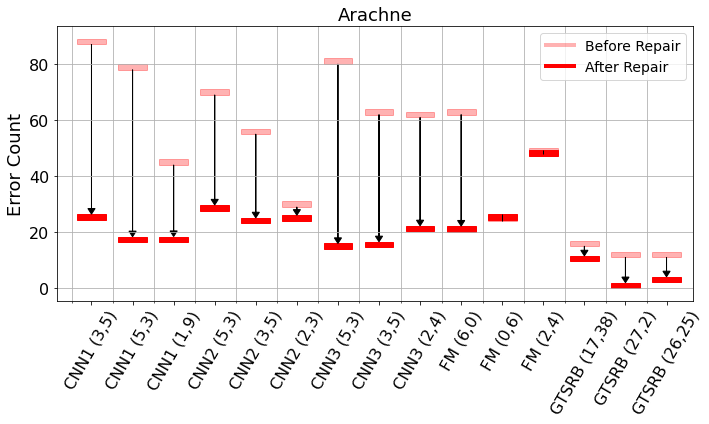

In [34]:
filepath = "/Users/jeongju.sohn/workdir/Journals/autopatch_nn_icse20/figures/rev/rq5/arachne.pdf"
plot_generalisability_in_one(
    cnts_chg, misclf_types, title = 'Arachne', figsize = (10,6), filepath = filepath)

In [38]:
cnts_chg

{('cnn1', 0): {'init': 87, 'after': 24.466666666666665},
 ('cnn1', 1): {'init': 78, 'after': 16.4},
 ('cnn1', 2): {'init': 44, 'after': 16.466666666666665},
 ('cnn2', 0): {'init': 69, 'after': 27.733333333333334},
 ('cnn2', 1): {'init': 55, 'after': 23.133333333333333},
 ('cnn2', 2): {'init': 29, 'after': 24.066666666666666},
 ('cnn3', 0): {'init': 80, 'after': 14.0},
 ('cnn3', 1): {'init': 62, 'after': 14.6},
 ('cnn3', 2): {'init': 61, 'after': 20.3},
 ('fm', 0): {'init': 62, 'after': 20.2},
 ('fm', 1): {'init': 24, 'after': 24.466666666666665},
 ('fm', 2): {'init': 48, 'after': 47.2},
 ('GTSRB', 0): {'init': 15, 'after': 9.566666666666666},
 ('GTSRB', 1): {'init': 11, 'after': 0.0},
 ('GTSRB', 2): {'init': 11, 'after': 2.1},
 'all': {'init': 736, 'after': 284.7}}

## Time Efficency

Currently, the localisation has been performed on cpu, meaning it has not reached the full speed (+ also, target the entire layers). Eevne

In [46]:
def time_of_execution(logfile):
    """
    currenlty r
    """
    import re
    
    overall_time_pat = "Time for patching:\s+([^\s]+)"
    loc_time_pat = "Time for total localisation:\s+([^\s]+)"
    
    overall_times = []
    loc_times = []
    with open(logfile) as f:
        for line in f.readlines():
            matched = re.match(overall_time_pat, line)
            if bool(matched):
                out = "".join(matched.groups())
                overall_exe_scnds = eval(out)
                overall_times.append(overall_exe_scnds)
                
            matched = re.match(loc_time_pat, line)
            if bool(matched):
                out = "".join(matched.groups())
                loc_exe_scnds = eval(out)
                loc_times.append(loc_exe_scnds)
            #overall_times.append(overall_exe_scnds)
            #loc_times.append(loc_exe_scnds)
        
    assert len(overall_times) == 1 and len(loc_times) == 1, "{} ({}) vs {} ({})".format(
        len(overall_times), overall_time_pat, len(loc_times), loc_time_pat)
    
    return overall_times[0], loc_times[0]

In [47]:
time_of_execution("../logs/rq5/fm/fm.rq5.0.0.out")

(167.35584235191345, 38.7704656124115)

In [48]:
def get_avg_exec_times(logdir, top_n = 0):
    """
    """
    import glob 
    logfiles = glob.glob(os.path.join(logdir, "*.rq5.{}.*.out".format(top_n)))
    
    overall_times = []
    for logfile in logfiles:
        overall_time, _ = time_of_execution(logfile)
        overall_times.append(overall_time)
    
    return np.mean(overall_times)

In [58]:
import datetime

### CNN1

In [60]:
t_scnds = get_avg_exec_times("../logs/rq5/cnn1", top_n = 0)
str(datetime.timedelta(seconds = t_scnds))

'0:02:06.441917'

### CNN2

In [61]:
t_scnds = get_avg_exec_times("../logs/rq5/cnn2", top_n = 0)
str(datetime.timedelta(seconds = t_scnds))

'0:06:07.711695'

### CNN3

In [62]:
t_scnds = get_avg_exec_times("../logs/rq5/cnn3", top_n = 0)
str(datetime.timedelta(seconds = t_scnds))

'0:06:40.483300'

### GTSRB

In [63]:
t_scnds = get_avg_exec_times("../logs/rq5/GTSRB", top_n = 0)
str(datetime.timedelta(seconds = t_scnds))

'0:23:19.195311'

### Fashion MNIST

In [64]:
t_scnds = get_avg_exec_times("../logs/rq5/fm", top_n = 0)
str(datetime.timedelta(seconds = t_scnds))

'0:02:18.971900'